### TODO
- Make the cumulative plot track every single change (timeentries are adden when they where added, and don't count for the day as a whole)
- Show date in bar plots
- Implement caching of all data entries
- generalize other code so it goes further back in time

In [1]:
CLEAR_NAME_CACHE = False
CLEAR_PLOTS = False

In [2]:
import requests
import base64
import json
import gc
import os
import time
import datetime as dt
from datetime import datetime, date
import pytz
import diskcache
import urllib.parse
from matplotlib import pyplot as plt
plt.rcParams.update({'font.family': 'Noto Sans CJK JP'})
import numpy as np
from operator import itemgetter, attrgetter
import pandas as pd
from pdb import set_trace
from IPython.display import clear_output
from glob import glob as glob
import math
import pickle
from multiprocessing import Process
import socket
import yaml
import json
import random
import matplotlib.patheffects as path_effects

In [3]:
with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
project_dir = os.path.abspath('')

project_id_names = diskcache.Cache(f"{project_dir}/project_id_names.cache")

def project_color(project_id):
    return project_id_names[project_id]['color']

In [5]:
if CLEAR_PLOTS:
    for f in glob("plots/*"):
        os.remove(f)
        
if CLEAR_NAME_CACHE:
    project_id_names.clear()
    
if not os.path.isdir("plots"):
    os.mkdir("plots")

# Functionality

## Utils

In [6]:
def now():
    return datetime.utcnow().replace(tzinfo=pytz.utc)

def filter_dict(d, keys):
    return list(map(lambda x: {k: v for k, v in x.items() if k in keys}, d))

## Setting up Toggl API
Note that a safe API request rate is 1 request per second.

In [7]:
API_version = 'v9'
prefix = f"https://api.track.toggl.com/api/"

API = {
    "time_entries" :          prefix + "v8" + "/time_entries",
    "get_current_time_entry": prefix + API_version + "/me/time_entries/current", 
    "me_info" :               prefix + API_version + "/me",
    "projects_me" :           prefix + API_version + "/me/projects",
    "projects_ws" :           prefix + API_version + "/workspaces/4143224/projects",
    "workspaces" :            prefix + API_version + "/workspaces",
}

with open(f"{project_dir}/api_key.txt") as f:
    API_token = f"{f.read()}:api_token"
API_token_base64 = base64.b64encode(API_token.encode('ascii')).decode('ascii')



In [8]:
def fetch(url, headers={}):
    headers={"Content-Type": "application/json", 
                                    "Host": "api.track.toggl.com",
                                    "authorization": f"Basic {API_token_base64}", 
                                    **headers}
    r = requests.get(url, headers=headers)
    return json.loads(r.content.decode('utf-8'))

def fetch_project(project_id):
    return fetch(f"{API['projects_ws']}/{project_id}")

In [9]:
def update_current_time_entry_duration(time_entry):
    time_entry["duration"] = (datetime.utcnow().replace(tzinfo=pytz.utc) - \
                              time_entry["start"]).seconds
    return time_entry

def get_time_entries(start_date, end_date):
    date_to_str = lambda date: date.strftime('%Y-%m-%dT%H:%M:%S') + f'{date.strftime("%z")[:3]}:{date.strftime("%z")[3:]}'
    url_exts = '?'
    url_exts += f"start_date={urllib.parse.quote(date_to_str(start_date))}"
    url_exts += f"&end_date={urllib.parse.quote(date_to_str(end_date))}"
    time_entries = fetch(API['time_entries'] + url_exts)
        
    time_entries = [x for x in time_entries if 'pid' in x]
        
    for time_entry in time_entries:
        project_id = time_entry['pid']
        if project_id not in project_id_names:
            project_id_names[project_id] = fetch_project(project_id)
        time_entry['project_name'] = project_id_names[project_id]['name']
        
        time_entry['start'] = datetime.fromisoformat(time_entry['start'])
        if 'stop' in time_entry:
            time_entry['stop'] = datetime.fromisoformat(time_entry['stop'])
        if time_entry['duration'] < 0:
            time_entry = update_current_time_entry_duration(time_entry)        
    return time_entries

def get_day_entries(date):
    # TODO
    start_date = datetime.fromisoformat(f'{str(date)}T01:00:00+00:00')
    end_date = datetime.fromisoformat(f'{str(date)}T23:59:59+00:00')
    return get_time_entries(start_date, end_date)

def get_todays_entries():
    return get_day_entries(date.today())

def get_last_n_days(n):
    entries = []
    for i in range(n):
        entries.append(get_day_entries(date.today() - dt.timedelta(n-1-i)))
    return entries

## Time entry processing

In [10]:
def accumulate(entries):
    times = {}
    for entry in entries:
        times[entry['pid']] = times.get(entry['pid'], 0) + entry['duration']
    return sorted(list(times.items()), key=itemgetter(1))

def n_acc(n, sleep=False):
    entries = get_last_n_days(n)
    entries = list(map(accumulate, entries))
    return entries

def filter_sleep(entries):
    "The expected format is [[]]. Each list element at depth 1 represents a day. A list item at depth two represents a time entry."
    return [[(k,v) for k,v in x if k != 163125866] for x in entries]

In [11]:
project_names_id = {}
for p in project_id_names:
    project_names_id[project_id_names[p]['name']] = p

# Goals

185499583 morning
163125874 improvements
165777572 social productive社会的、生産的
186239363 evening
163125866 sleep睡眠
187567761 unknown
165947128 entertainment
165352471 communicationコミュニケーション
165598846 cook食べ物
165297879 maintenanceメンテナンス
187511108 nonfiction, listen
163125865 meditate瞑想
184591500 commute
185247273 write
165296570 toiletトイレ
165304788 sportトレニング
163126231 eat食べる
165296445 social社会的
186567117 life_debugging
165297234 plan計画
163125846 tulpa_training
165301785 AIA_original
187084115 aia_discussion
186119188 reflect
165296497 research研究
185725569 frisky
186454695 SERI_MATS_event
185927511 AIA_skillup
165354205 shopping買い物
187650764 N87
169322498 music_organization
178004458 youtube-produce
169680640 reading_non-fiction
165302994 nap睡眠_nap
165335481 showerシャワー
186291374 AIA_communicate
187708034 improvement, plan
165452212 idea_formulation
165613431 music_discovery
182726911 find_flat
168113610 learn_steno
187852475 read, alignment forum
187853378 write, alignment forum


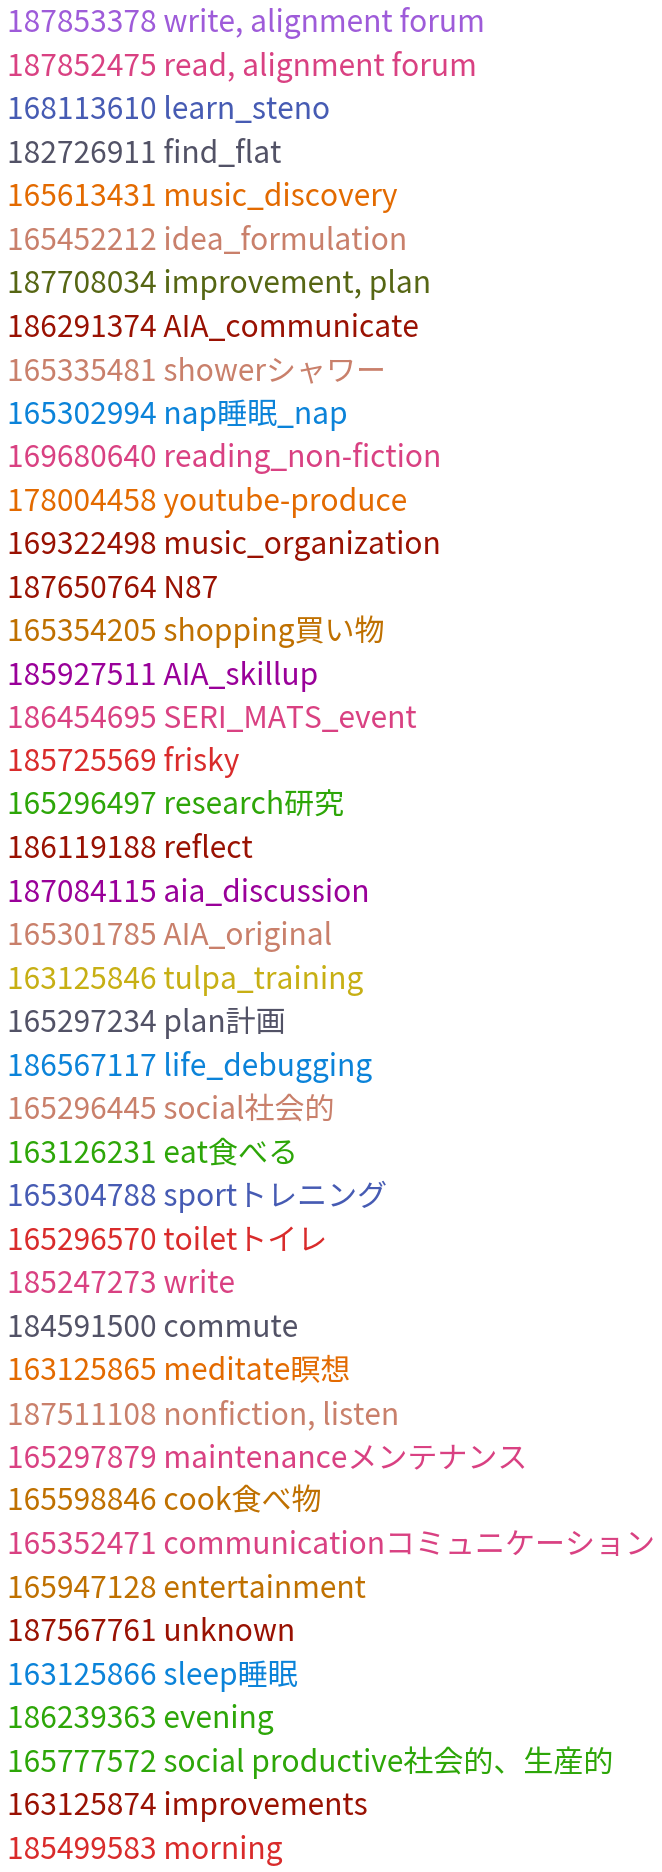

In [12]:
for i, k in enumerate(project_id_names):
    c = f"{k} {project_id_names[k]['name']}"
    print(c)
    txt = plt.text(0, i*0.2, c, color=project_color(k), size=30)
    plt.axis('off')

In [13]:
print("Daily goals, given as project_id and minutes:")
daily_goals = [
               (186119188, 10), # Reflect           
               (163125865, 40), # Meditate           
               (165304788, 30), # Sport
               (163125846, 10), # Tulpa training
               (165301785, 90), # AIA original                   
               (185927511, 25), # AIA_skillup
               (186291374, 25), # AIA_explain
               (187852475, 25), # read
               (168113610, 15), # Steno
             ]
daily_goals = [(pid, project_id_names[pid]['name'], mins*60) for pid, mins in daily_goals]
for i in daily_goals:
    print(i)
print()
daily_goals.reverse()

Daily goals, given as project_id and minutes:
(186119188, 'reflect', 900)
(163125865, 'meditate瞑想', 2400)
(165304788, 'sportトレニング', 1800)
(163125846, 'tulpa_training', 600)
(165301785, 'AIA_original', 5400)
(185927511, 'AIA_skillup', 1500)
(186291374, 'AIA_communicate', 1500)
(187852475, 'read, alignment forum', 1500)
(168113610, 'learn_steno', 900)



# Visualisations

In [14]:
def general_axis(ax):
    ax.set_facecolor('white')
    return ax

In [15]:
def cumulative_plot(axs, data, daily_goals, limit_y=True):
    text_size = 14
    plot_y_lim = 1.2
    axs.grid(which='both')
    general_axis(axs)
    day = data[0]
    day_d = dict(day)
    percents = [np.array([day_d.get(pid, 0) / seconds / len(data) for pid,name,seconds in daily_goals])]
    for i, day in enumerate(data[1:]):
        day_d = dict(day)
        percents.append(np.array(percents[-1]) + np.array([day_d.get(pid, 0) / seconds / len(data) 
                                                           for pid,name,seconds in daily_goals]))
    percents = np.array(percents)
    for i in range(percents.shape[1]):
        col = project_color(daily_goals[i][0])
        axs.plot(np.arange(-percents.shape[0]+1, 1), percents[:,i], label=daily_goals[i][1], 
                 linewidth=7.5, alpha=0.7, color=col)
        target = percents[-2,i] + (1 / (len(percents) - 1))
        color = 'red' if percents[-1,i] <= percents[-2,i] + 5 else 'orange' if percents[-1,i] < target else 'green'
        # Plot lines indicating todays goal
        axs.plot([-1, 0], [percents[-2,i], target], linestyle='dotted', linewidth=3.5,
                 color=col, alpha=0.7)
        axs.plot(0, target, marker=4, markersize=15, color=col, alpha=0.7)
        axs.plot(0.1, target, 'o', markersize=15, color=color, alpha=0.7)
        if not limit_y:
            axs.text(0, percents[-1,i], str(daily_goals[i][1]), va='center')
        else:
            for j in range(percents.shape[0]):
                if percents[j,i] > plot_y_lim and j > 0 and percents[j-1,i] < plot_y_lim:
                    axs.text(-7+j, percents[j-1,i], str(daily_goals[i][1]), va='center')
                    break
            else:
                if percents[j-1,i] < plot_y_lim:
                    axs.text(0, percents[-1,i], str(daily_goals[i][1]), va='center')
                
    axs.plot(0,1,marker=4, markersize=12, color='black', alpha=0.5)
    axs.plot([-6,0],[0,1], linestyle='dashed', label='target', linewidth=3, alpha=0.2, color='black')
    if limit_y:
        axs.set_ylim(-0.03, plot_y_lim)
    axs.legend()

def generate_cumulative_plot(acc_7, show_plot=True):
    text_size = 14
    scale = 1.5*1.41
    
    fig, axs = plt.subplots(1,1,figsize=(16*scale,9*scale))
    figtitle = "S00_cumulative_goals_1"
    fig.suptitle(figtitle, fontsize=text_size*3)
    cumulative_plot(axs, acc_7, daily_goals)
    plt.savefig(f"plots/{figtitle}.svg", facecolor='white', transparent=False, bbox_inches='tight')
    
    fig, axs = plt.subplots(1,1,figsize=(16*scale,9*scale))
    figtitle = f"S{100-20}_cumulative_goals_2_no_ylimit"
    fig.suptitle(figtitle, fontsize=text_size*3)
    cumulative_plot(axs, acc_7, daily_goals, limit_y=False)
    plt.savefig(f"plots/{figtitle}.svg", facecolor='white', transparent=False, bbox_inches='tight')
    
    if show_plot:
        plt.show()

In [16]:
def goal_plot(axs, daily_goals, acc):
    text_size = 14
    red_percent = 5
    y_pos = np.arange(len(daily_goals))
    d_acc = dict(acc)
    percents = [max(d_acc.get(pid, 0) / seconds * 100, 1) for pid,name,seconds in daily_goals]
    general_axis(axs)
    axs.grid(axis='x')
    color = []
    for p in percents:
        color.append('red' if p < red_percent else ('orange' if p < 100 else 'lime'))
    axs.barh(y_pos, percents, color=color, alpha=0.7)
    axs.tick_params(axis='x', labelsize=text_size)
    axs.set_yticks(y_pos, labels=[name for _,name,_ in daily_goals], size=text_size)
    axs.axvline(red_percent, color='orange')
    axs.axvline(100, color='green')
    axs.set_xlim(0, 115)
    for y, (pid,name,target) in zip(y_pos, daily_goals):
        axs.text(3, y, f"{dt.timedelta(seconds=d_acc.get(pid, 0))} / {dt.timedelta(seconds=target)}", 
                 size=text_size, va='center')
    return axs

def generate_goal_plot(acc_7, show_plot=True):
    scale = 1.5
    text_size = 14
    fig, axs = plt.subplots(3, 2, figsize=(17*scale, 9*scale))
    figtitle = f"S{100-10}_goals"
    fig.suptitle(figtitle, fontsize=text_size*3)
    axs = axs.flatten()
    for i, a in enumerate(reversed(acc_7[1:])):
        goal_plot(axs[i], daily_goals, a)
        date = datetime.now() - dt.timedelta(i)
        axs[i].set_title(date.strftime('%Y-%m-%d %A'))
    plt.savefig(f"plots/{figtitle}.svg", facecolor='white', transparent=False, bbox_inches='tight')
    if show_plot:
        plt.show()

In [17]:
def bar(ax, data):
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    for j, d in enumerate(data): 
        height = 0
        cmap = plt.cm.get_cmap('hsv', len(d))
        inverse_shrink = 5
        for i, (project_id, time) in enumerate(reversed(d)):
            project_name = project_id_names[project_id]['name']
            time_scaled =  time/(60*60)
            new_height = height + time_scaled
            ax.bar(j, height=time_scaled, tick_label='Today', alpha=0.7, color=project_color(project_id), bottom=height, edgecolor='black')
            ax.text(j, new_height, str(dt.timedelta(seconds= time)) + ' ' + project_name, va='top', ha='center', size=8)
            height = new_height
    return ax

def generate_bars(acc_7, acc_7_nosleep, show_plot=True):
    text_size = 14
    scale = 1.5*1.41
    fig, axs = plt.subplots(1,1,figsize=(16*scale,9*scale))
    figtitle = "S20_bar_1"
    fig.suptitle(figtitle, fontsize=text_size*3)
    bar(axs, acc_7)
    axs.axhline(24, color='red')
    plt.savefig(f"plots/{figtitle}.svg", facecolor='white', transparent=False, bbox_inches='tight')
    if show_plot:
        plt.show()

    fig, axs = plt.subplots(1,1,figsize=(16*scale,9*scale))
    figtitle = "S50_bar_2_no-sleep"
    fig.suptitle(figtitle, fontsize=text_size*3)
    bar(axs, acc_7_nosleep)
    plt.savefig(f"plots/{figtitle}.svg", facecolor='white', transparent=False, bbox_inches='tight')
    if show_plot:
        plt.show()

In [18]:
def pie(ax, data):
    pid, sizes = [x[0] for x in data], [x[1] for x in data]
    names = [project_id_names[p]['name'] for p in pid]
    names = [f"{name} {math.floor(size / (60*60))}:{math.floor(size / 60 % 60):02}" 
             for name, size in zip(names, sizes)]
    wedges = ax.pie(sizes, labels=names, colors=[project_color(p) for p in pid], autopct='%1.1f%%',
            shadow=False, startangle=180-45, explode=0.05 * np.random.rand(len(data)))
    for i in range(len(wedges[0])):
        wedges[0][i].set_alpha(0.7)
    return ax

def generate_pies(acc_7, acc_7_nosleep, show_plot=True):
    text_size = 14
    fig, axs = plt.subplots(1,1,figsize=(20,20))
    figtitle = "S50_pie_1"
    fig.suptitle(figtitle, fontsize=text_size*3)
    if acc_7[-1] != []:
        pie(axs, acc_7[-1])
    else:
        pie(axs, acc_7[-2])
    plt.savefig(f"plots/{figtitle}.svg", facecolor='white', transparent=False, bbox_inches='tight')
    if show_plot:
        plt.show()

    fig, axs = plt.subplots(1,1,figsize=(20,20))
    figtitle = "S10_pie_2_no-sleep"
    fig.suptitle(figtitle, fontsize=text_size*3)
    if acc_7_nosleep[-1] != []:
        pie(axs, acc_7_nosleep[-1])
    else:
        pie(axs, acc_7_nosleep[-2])
    plt.savefig(f"plots/{figtitle}.svg", facecolor='white', transparent=False, bbox_inches='tight')
    
    if show_plot:
        plt.show()

In [19]:
pickle_file = 'acc_7.pickle'

In [20]:
def fetch_single(msg='fetch time'):
    acc_7 = n_acc(7)
    with open(pickle_file, 'wb') as f:
        pickle.dump(acc_7, f)
    print(f"{msg}: {datetime.now()}")

def fetch_loop():
    WAIT = config['seconds_between_fetches']
    while True:
        try:
            fetch_single('loop fetch time')
        except ConnectionError:
            print(f"Connection error.")
        print(f"Fetch loop Sleeping {WAIT}s")
        time.sleep(WAIT)

In [21]:
SHOW_PLOTS = False

def generate_all_plots():
    with open(pickle_file, 'rb') as f:
        acc_7 = pickle.load(f)
    acc_7_nosleep = filter_sleep(acc_7)
    
    generate_cumulative_plot(acc_7, show_plot=SHOW_PLOTS)
    generate_goal_plot(acc_7, show_plot=SHOW_PLOTS)
    generate_bars(acc_7, acc_7_nosleep, show_plot=SHOW_PLOTS)
    generate_pies(acc_7, acc_7_nosleep, show_plot=SHOW_PLOTS)
    print(f"render done: {datetime.now()}")

In [22]:
def gen_fetch_gen():
    generate_all_plots()
    fetch_single()
    generate_all_plots()

Fetch loop started
loop fetch time: 2022-12-11 01:48:42.947880
Fetch loop Sleeping 90s
fetch time: 2022-12-11 01:48:42.989671
render done: 2022-12-11 01:48:44.574796


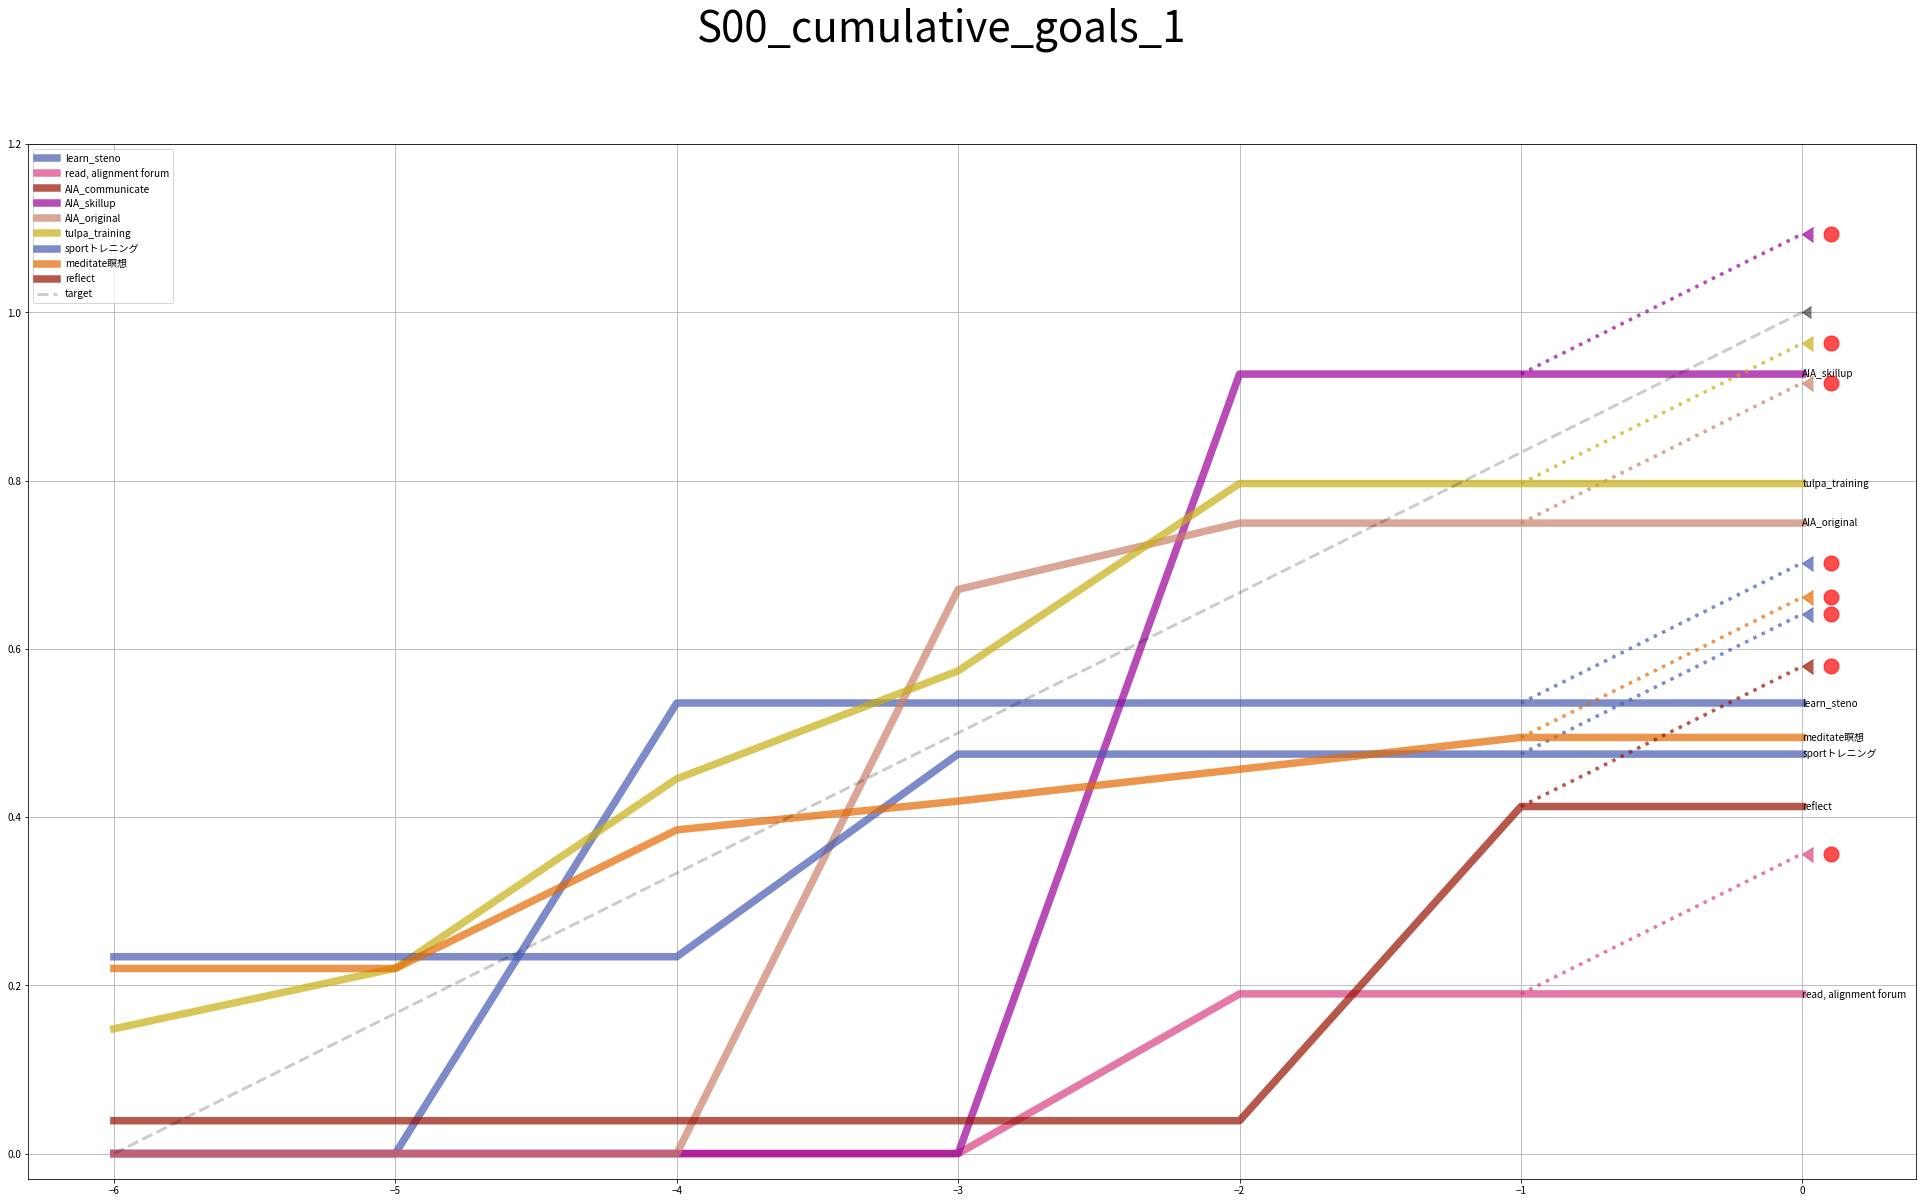

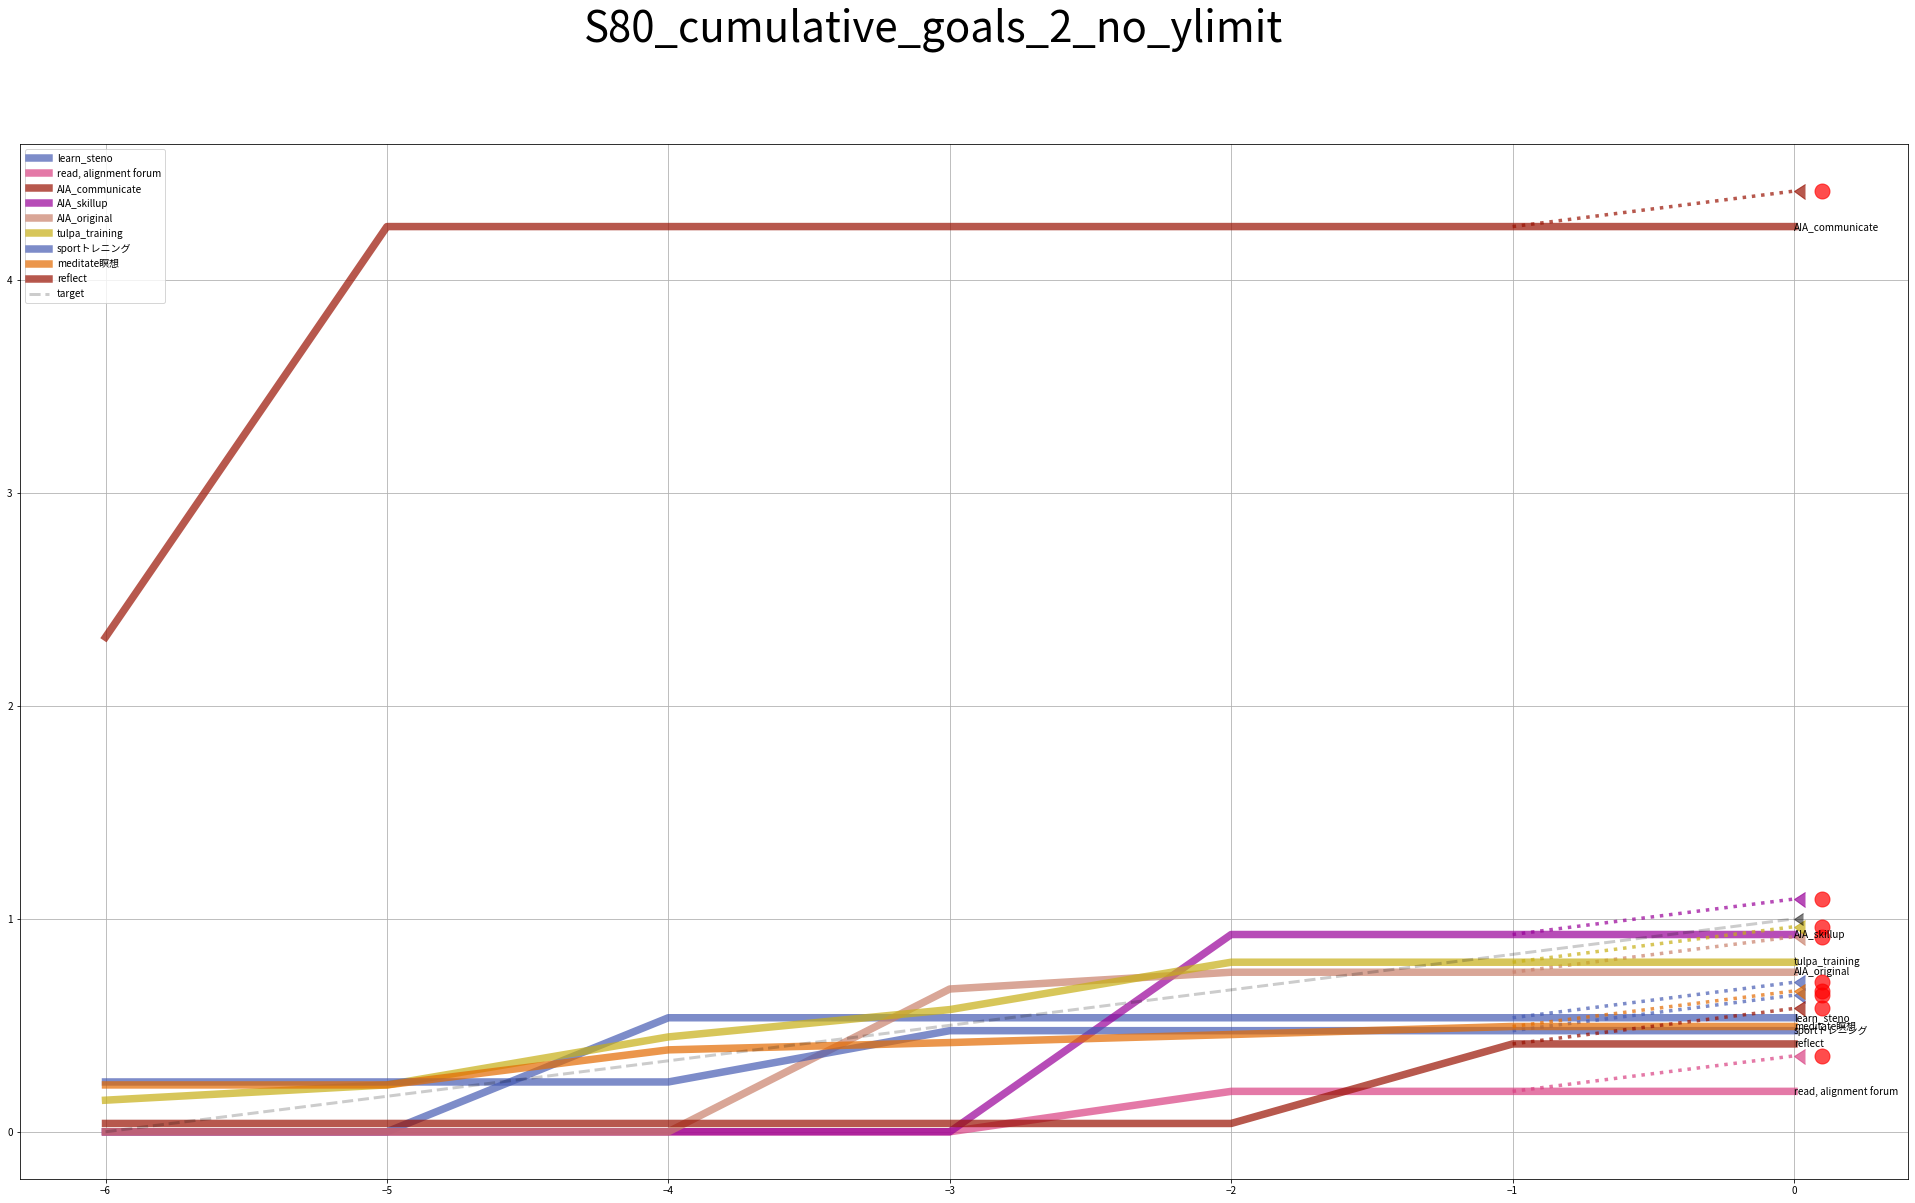

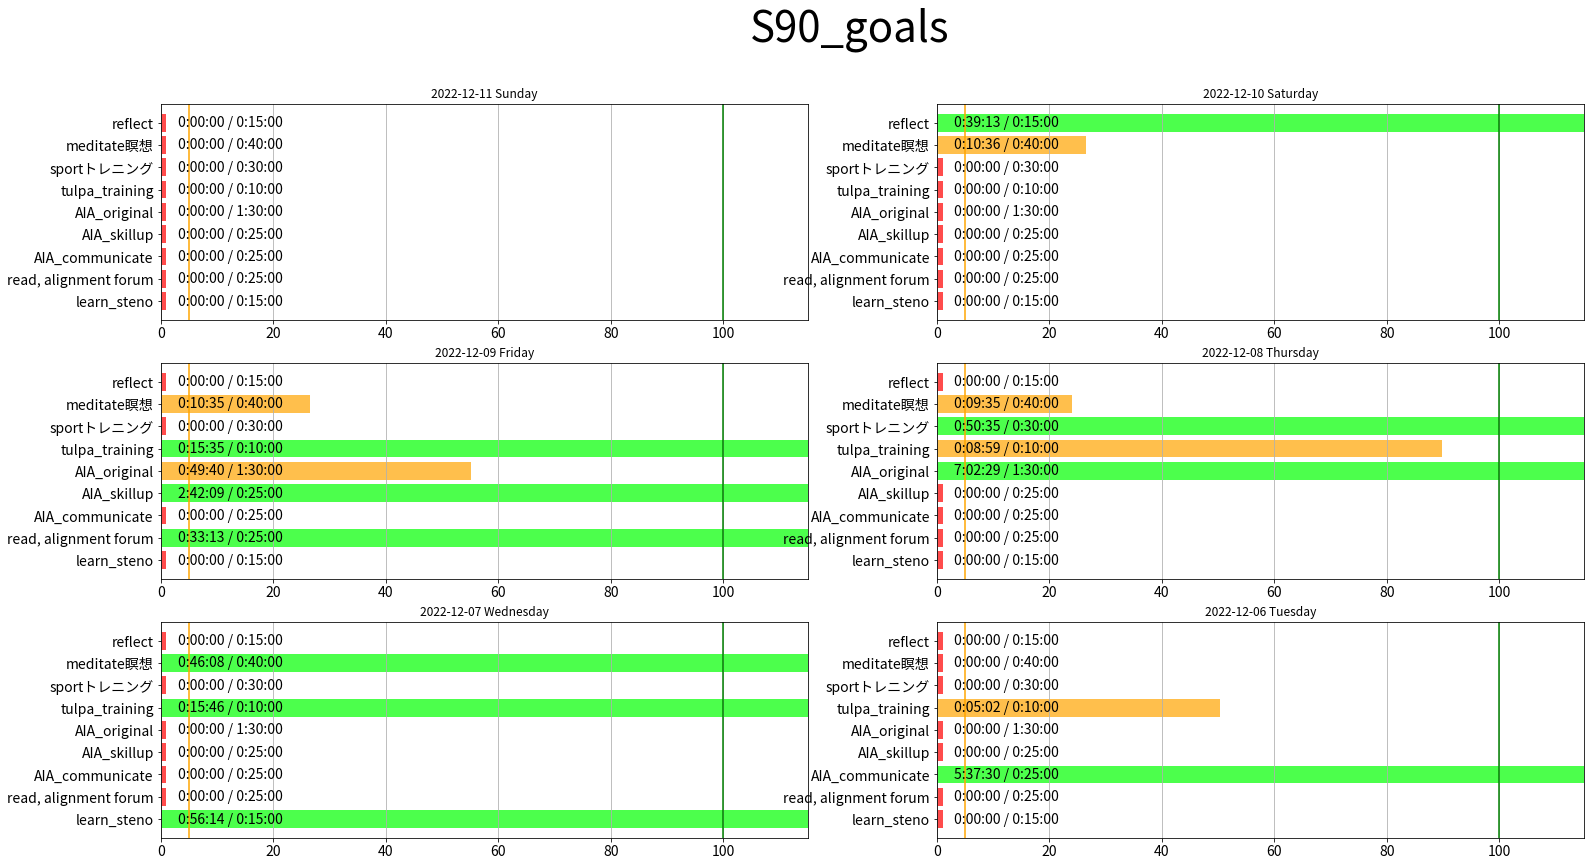

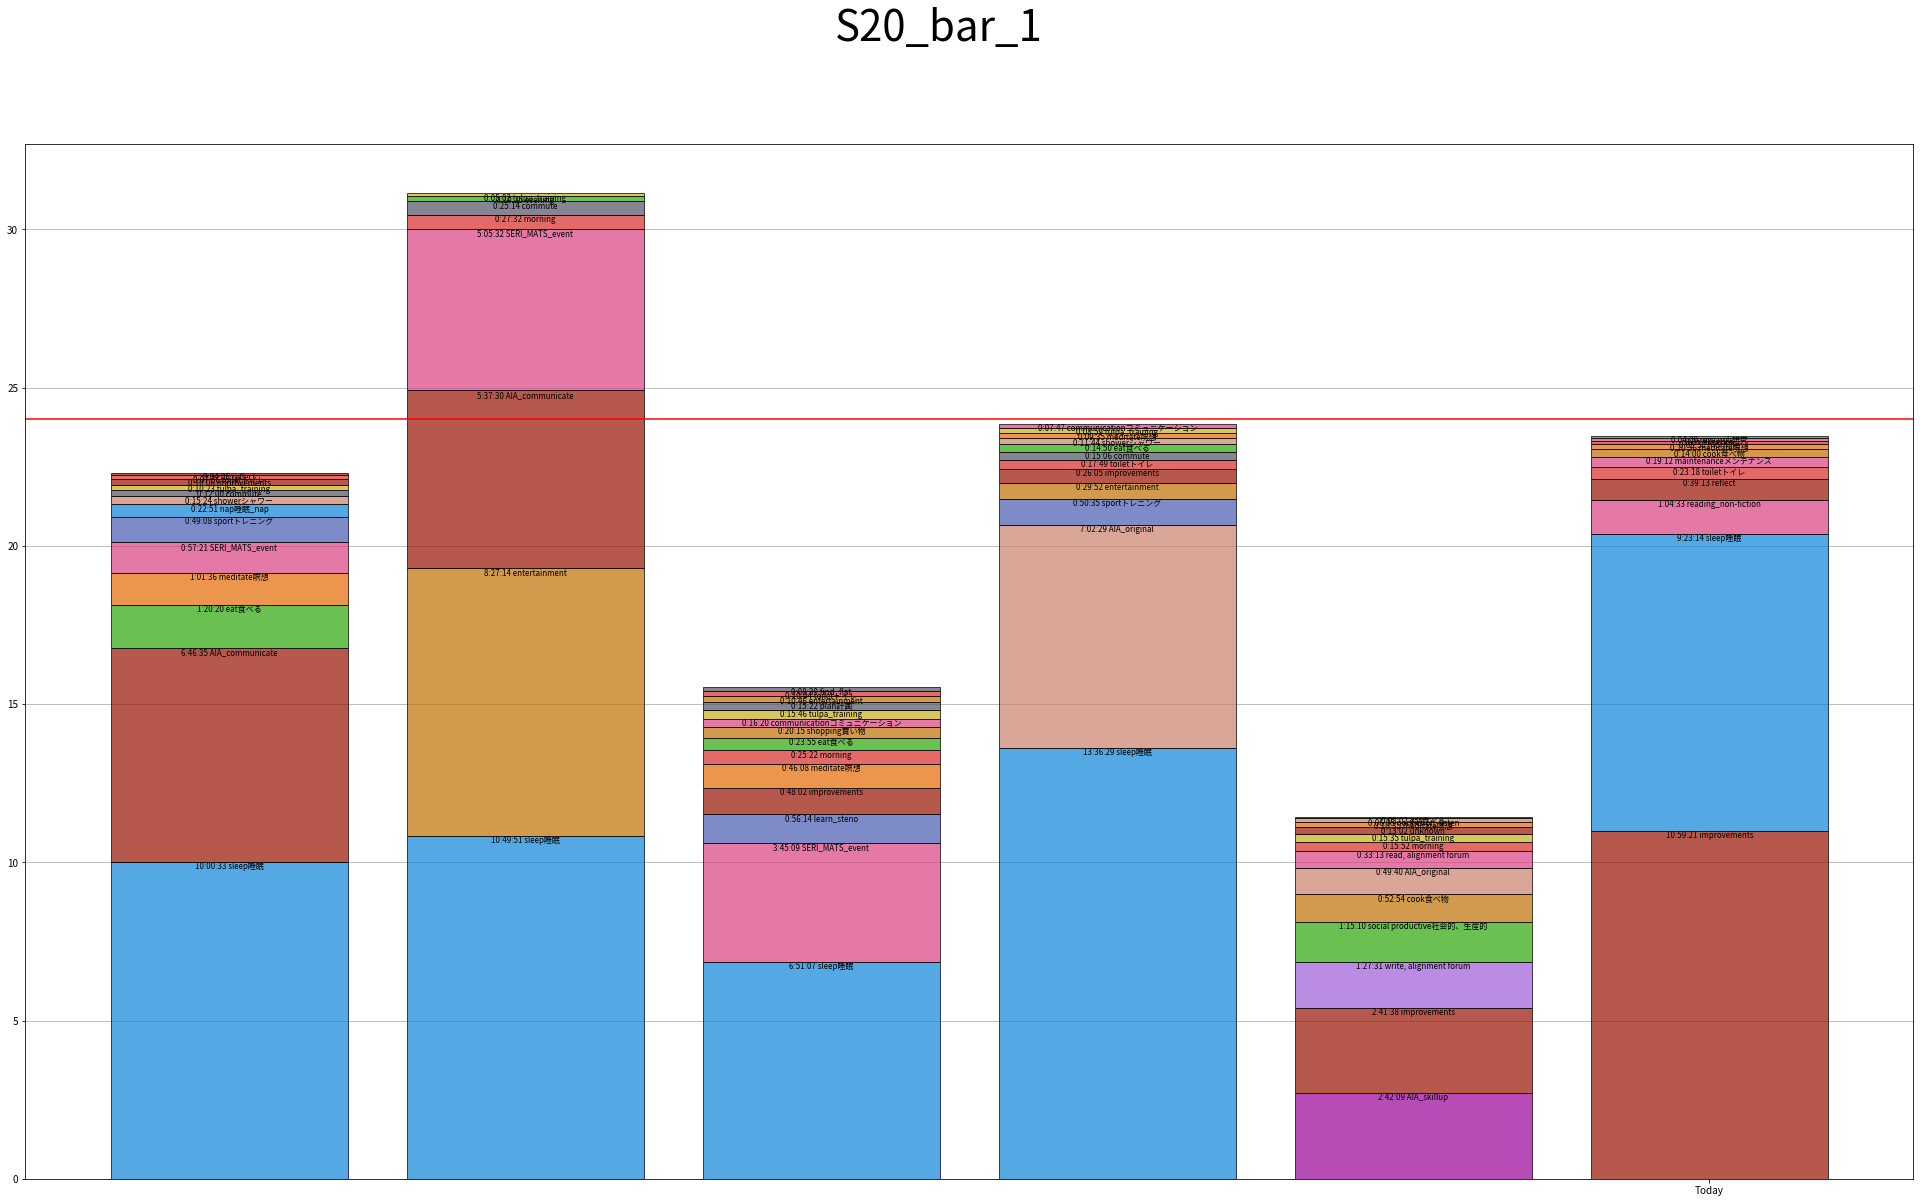

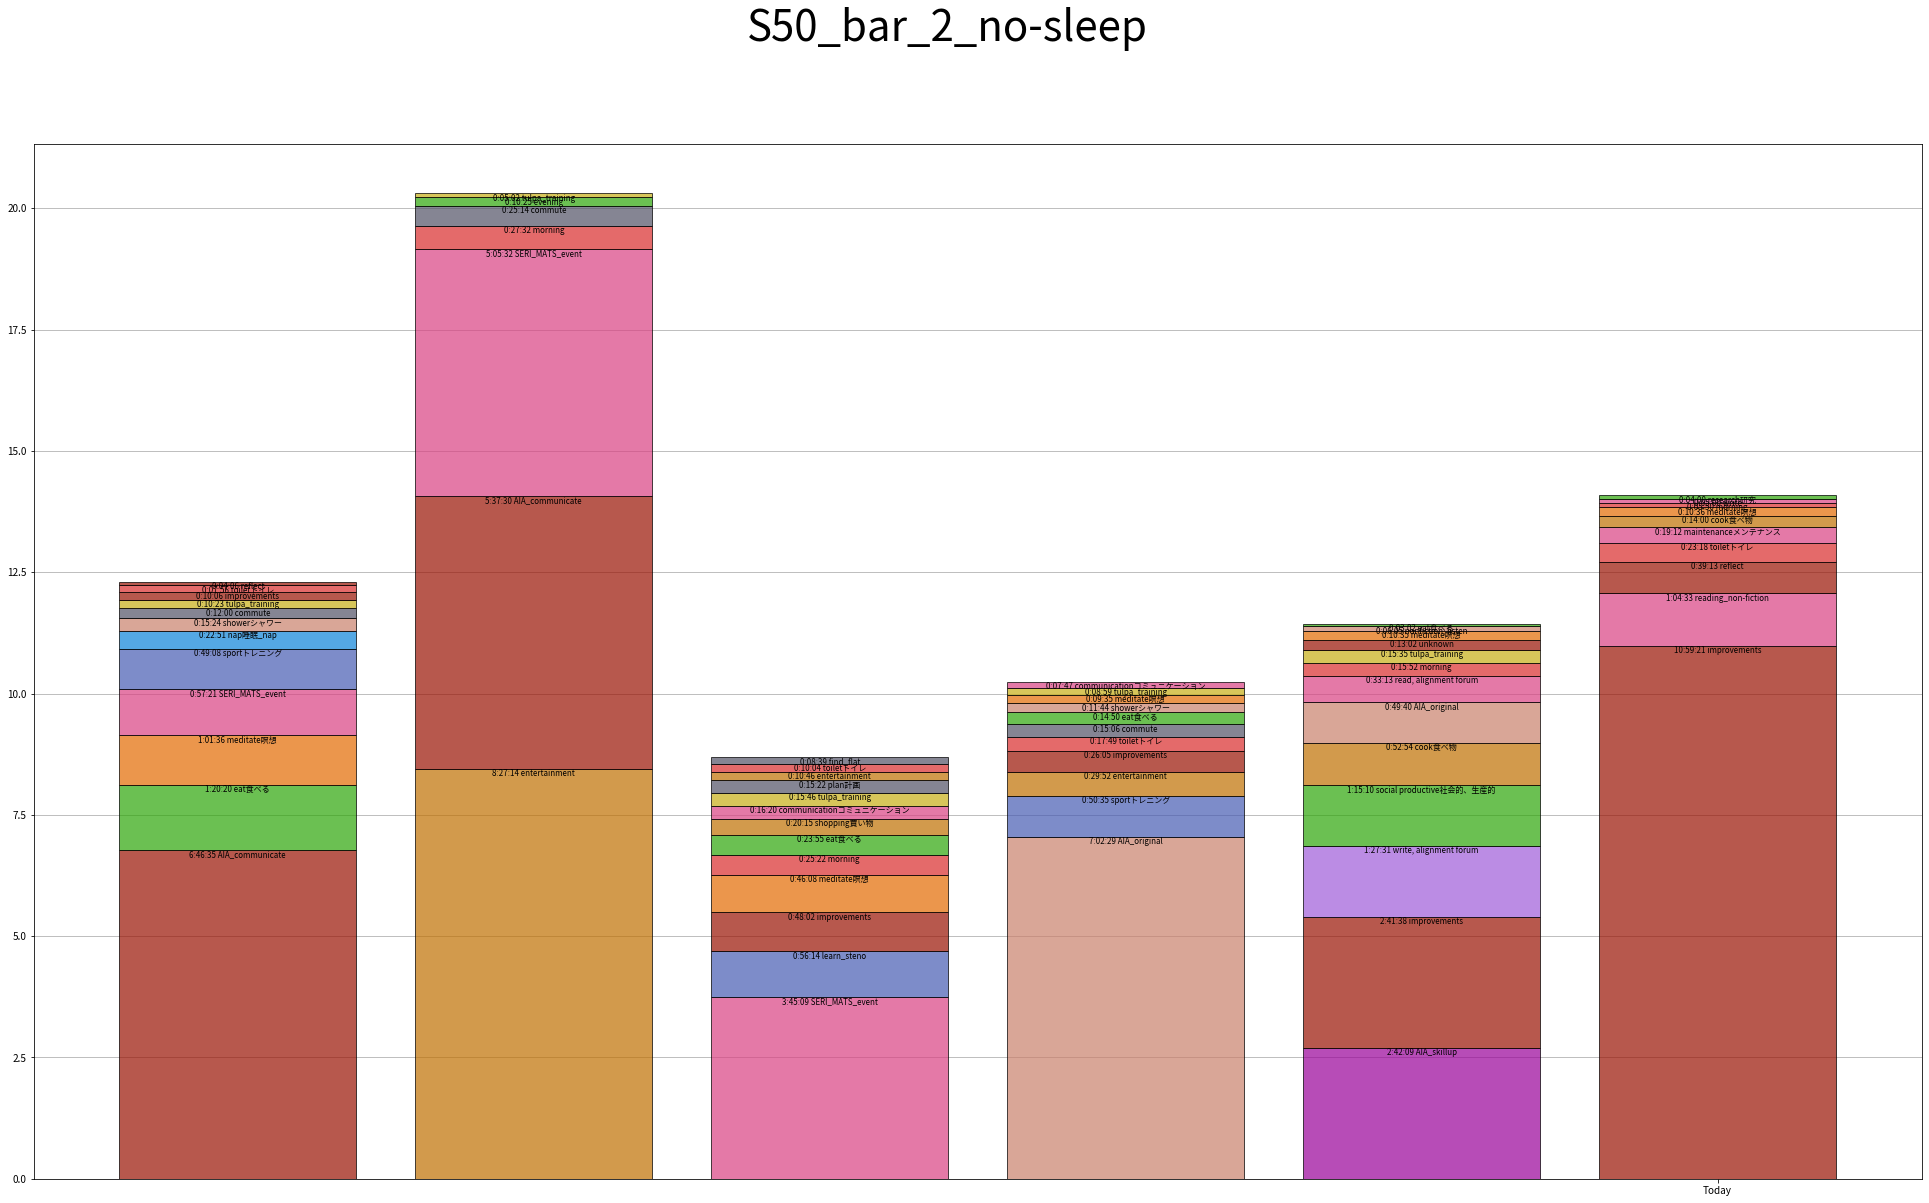

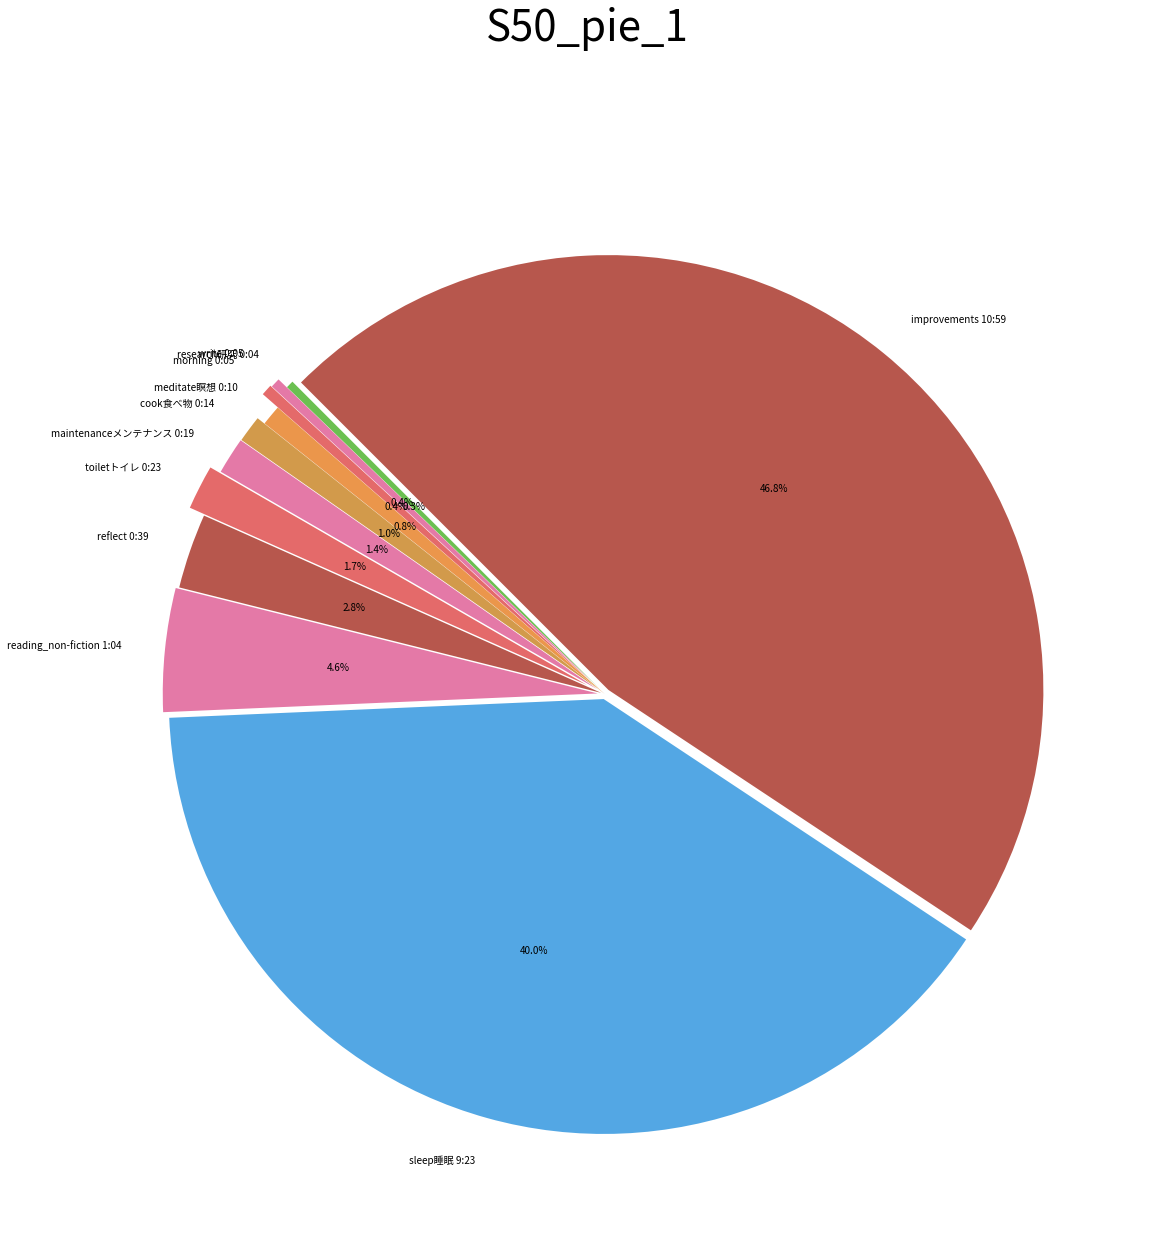

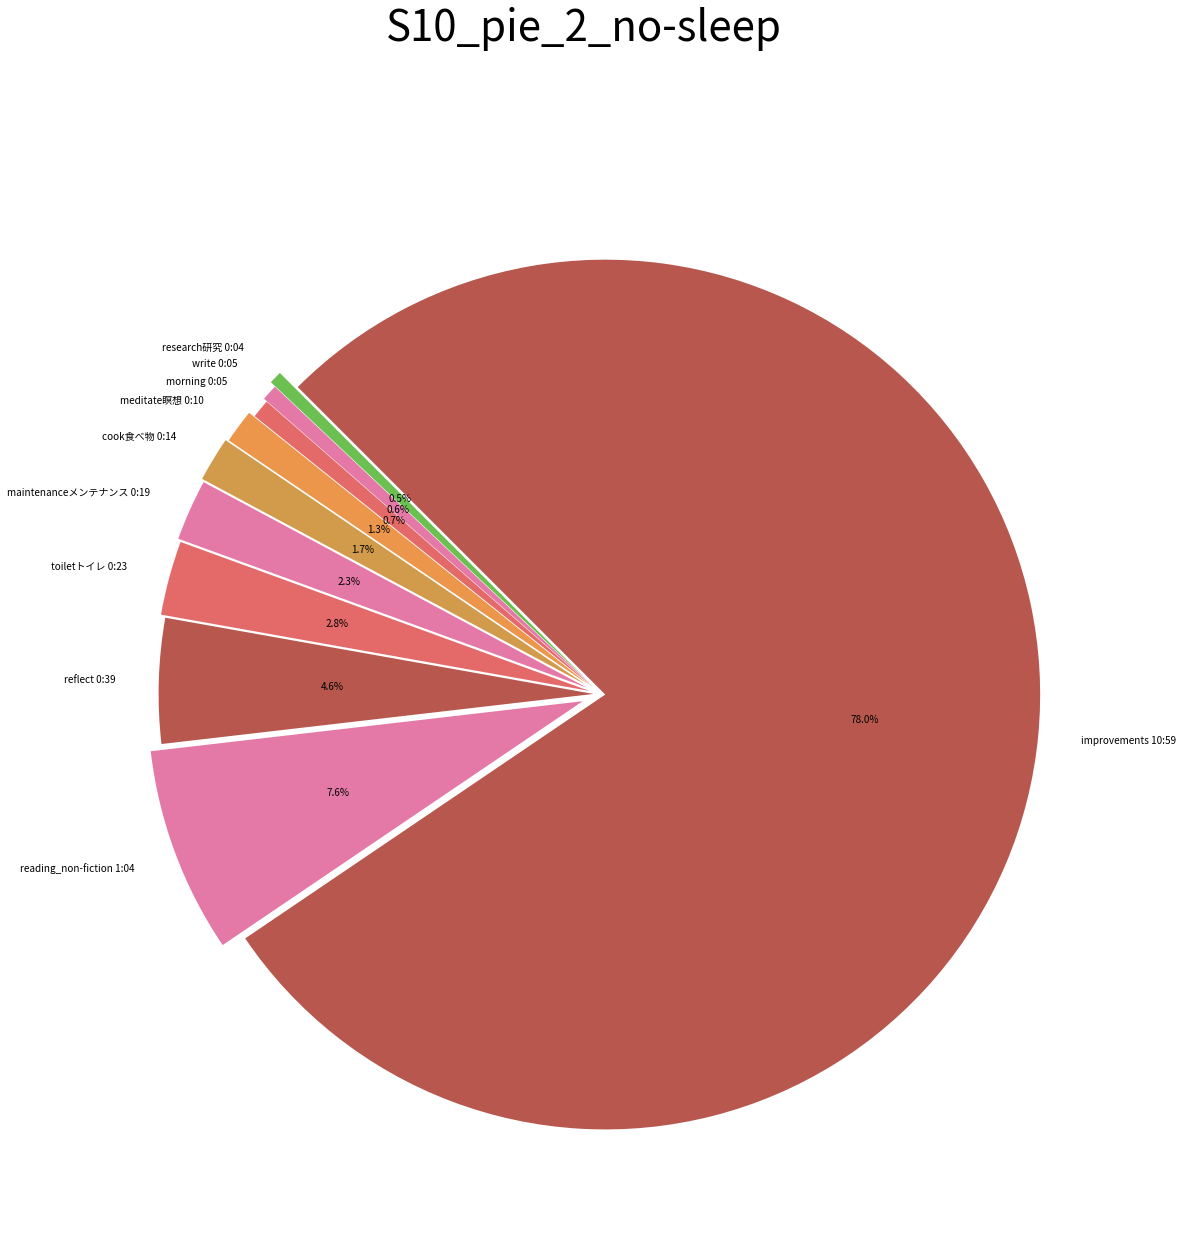

loop fetch time: 2022-12-11 01:50:16.584383
Fetch loop Sleeping 90s
loop fetch time: 2022-12-11 01:51:49.968365
Fetch loop Sleeping 90s
loop fetch time: 2022-12-11 01:53:23.560453
Fetch loop Sleeping 90s
loop fetch time: 2022-12-11 01:54:57.153372
Fetch loop Sleeping 90s
loop fetch time: 2022-12-11 01:56:30.334931
Fetch loop Sleeping 90s
loop fetch time: 2022-12-11 01:58:04.030865
Fetch loop Sleeping 90s


In [23]:
class commands:
    fetch = 'fetch'
    fetch_loop = 'fetch-loop'
    render = 'render'
    show = 'show'
    
fetch_loop_p = Process(target=fetch_loop)
fetch_loop_p.start()
print("Fetch loop started")

RUN_SERVER = False

if RUN_SERVER:
    with socket.socket() as sock:
        sock.bind((config['ip'], config['port']))
        sock.listen()
        print("Server waiting for connections")

        while True:
            client_connection, clinet_address = sock.accept()
            command = client_connection.recv(1024).decode('UTF-8')
            print(f"received: {command}")
            # TODO This does not work as intended
            if command == commands.fetch_loop:
                if fetch_loop_p.is_alive():
                    fetch_loop_p.kill()
                    msg = "Fetch loop terminated"
                else:
                    fetch_loop_p = Process(target=fetch_loop)
                    fetch_loop_p.start()
                    msg = "Fetch loop terminated"
            elif command == commands.show:
                p = Process(target=gen_fetch_gen)
                p.start()
                msg = "Showing plots"
            elif command == commands.fetch:
                p = Process(target=fetch_single)
                p.start()
                msg = "Singe Fetch started"
            elif command == commands.render:
                p = Process(target=generate_all_plots)
                p.start()
                msg = "Render started"
            else:
                msg = f"'{command}' is not a valid command.\n" \
                       "Valid commands are 'fetch', 'fetch-loop', 'show', 'render'."
            print('sending:', msg)
            client_connection.send(msg.encode())
else:
    fetch_single()
    generate_all_plots()